C:\Users\Admin\AppData\Local\Temp\ipykernel_29012\367757534.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c=df["time - norm"][:9], cmap=plt.cm.get_cmap('RdYlGn'), s=50)


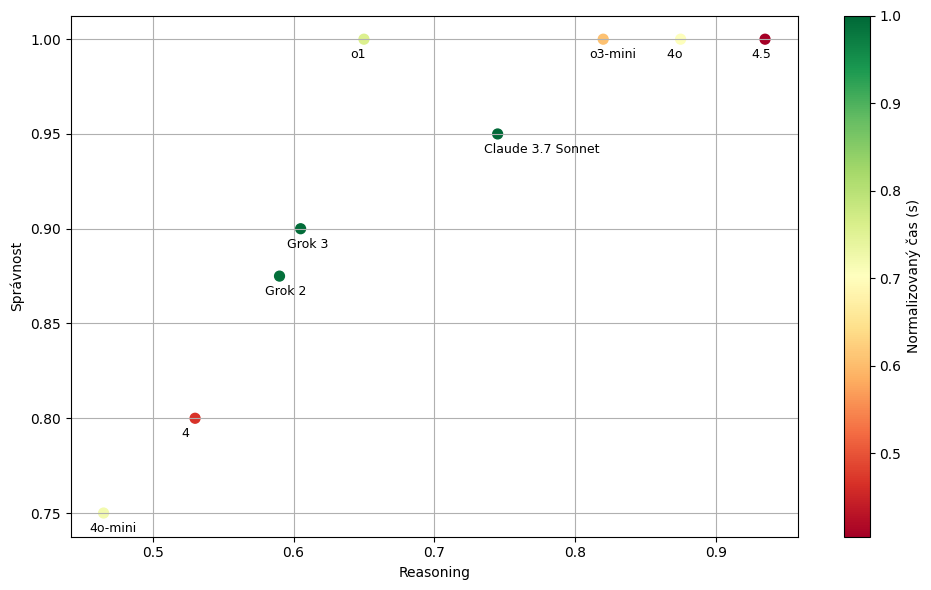

C:\Users\Admin\AppData\Local\Temp\ipykernel_29012\367757534.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sns.heatmap(df_viz.set_index("nazev"), annot=True, cmap=plt.cm.get_cmap('RdYlGn'), fmt=".2f")


<Figure size 1000x600 with 0 Axes>

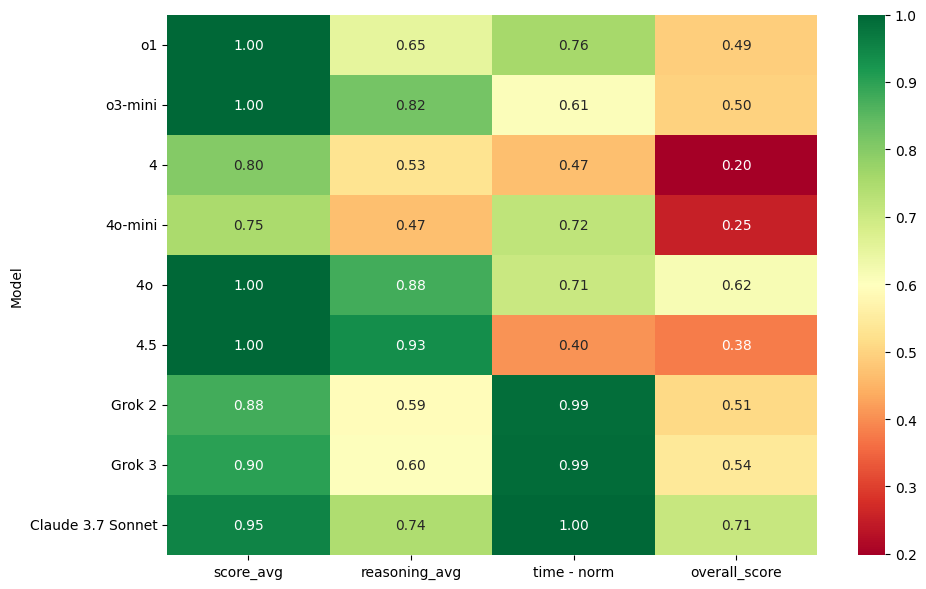

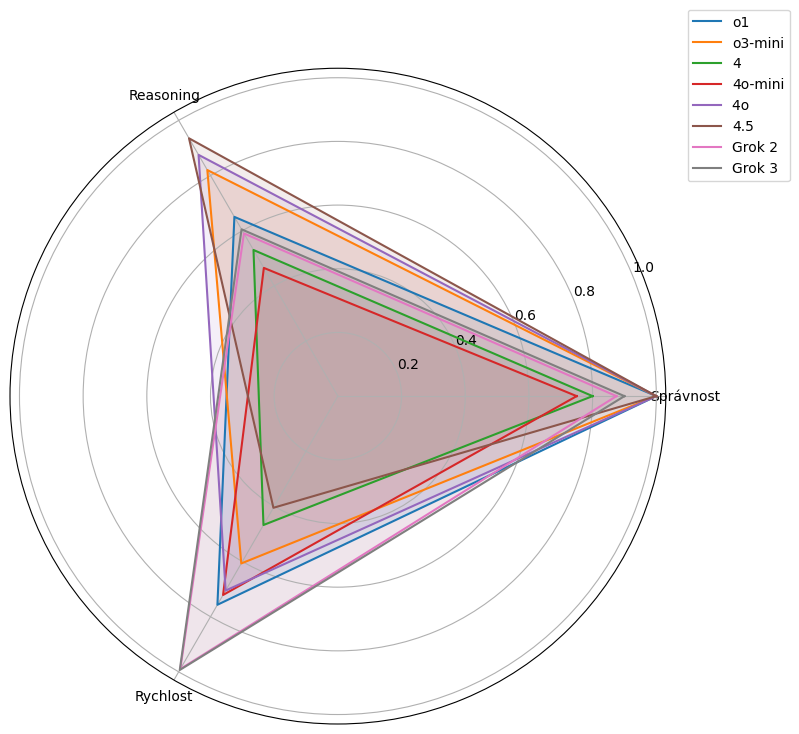

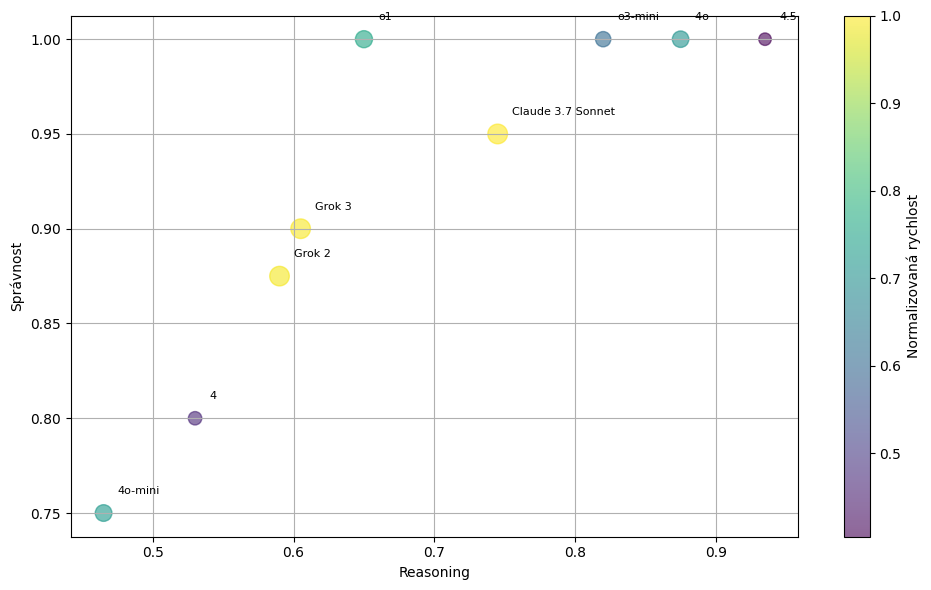

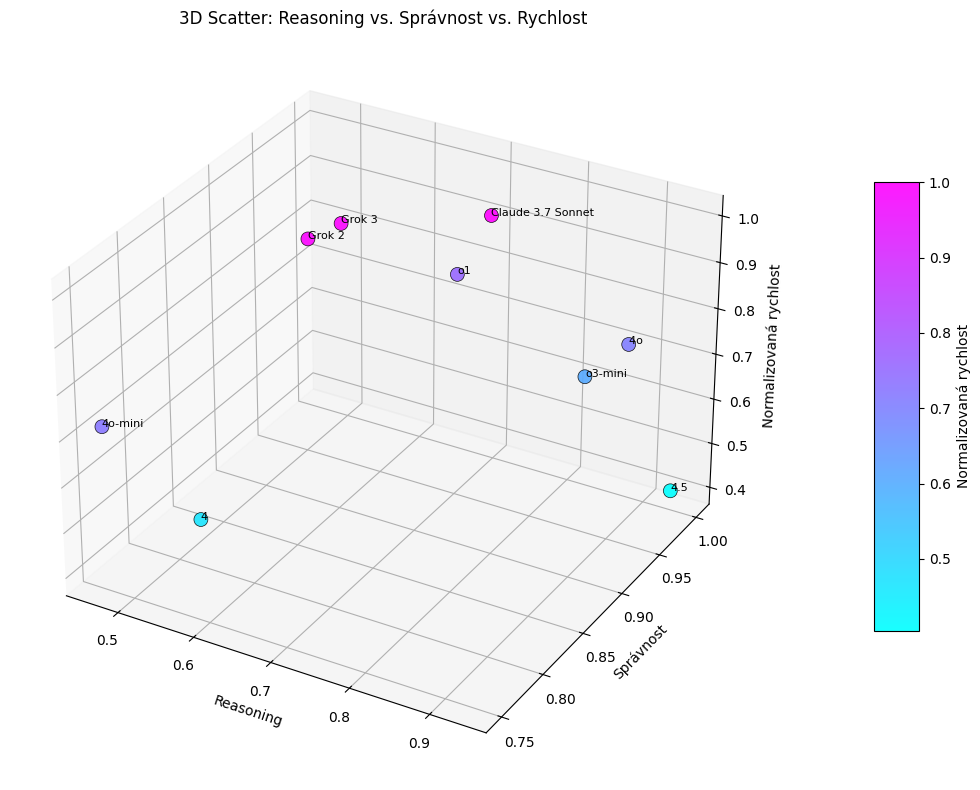

In [113]:
import csv
import pandas as pd
from uncertainties import ufloat
from uncertainties import unumpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np


df = pd.read_csv('data.csv', sep=',', header=0, encoding='utf-8')
#print(df.head())

#print(df.columns)




spravnost_cols = [col for col in df.columns if "znamka" in col]
reasoning_cols = [col for col in df.columns if "reasoning" in col]
time_cols = [col for col in df.columns if col.endswith("-t")]

df["score_avg"] = df[spravnost_cols].mean(axis=1)
df["score_err"] = df[spravnost_cols].std(axis=1)
df["reasoning_avg"] = df[reasoning_cols].mean(axis=1)
df["reasoning_err"] = df[reasoning_cols].std(axis=1)
df["time_avg"] = df[time_cols].mean(axis=1)
df["time_err"] = df[time_cols].std(axis=1)


ref_idx = 8  # referenční systém
ref_time = ufloat(df["time_avg"][ref_idx], df["time_err"][ref_idx])
df["time - norm"] = df.apply(
    lambda row: (ref_time / ufloat(row["time_avg"], row["time_err"])) if pd.notnull(row["time_avg"]) and row["time_err"] != 0 else None,
    axis=1
)
df["time - norm"] = unumpy.nominal_values(df["time - norm"])
df["time - norm err"] = unumpy.std_devs(df["time - norm"])
for i in range(1, 21):  # Adjusted range to match column naming convention
   #znamka_col = f"{i} - znamka"
   # reasoning_col = f"{i} - reasoning"
   time = f"{i}-t"
   k = 1/df[time][8]
   df[time] = 1/(df[time] * k)


#print(df[["score_avg", "score_err", "reasoning_avg", "reasoning_err", "time_avg", "time_err", "time - norm", "time - norm err"]])

df2 = df[["nazev","score_avg", "score_err", "reasoning_avg", "reasoning_err", "time - norm", "time - norm err"]].copy()

# print(df2[:9])


# plot = df2.plot.scatter(x="time - norm", y="score_avg", c="reasoning_avg", colormap='viridis', alpha=0.5, s=100)
# plot.set_xlabel("Normalized Time (s)", fontsize=14)
# plot.set_ylabel("Score", fontsize=14)
# plot.set_title("Scatter Plot of Score vs Normalized Time", fontsize=16)
# plot.grid(True)
# plot.figure.set_size_inches(10, 6)
# plot.figure.tight_layout()
# plot.figure.savefig("scatter_plot.png", dpi=300)
# plot.figure.show()

# plt.figure(figsize=(10, 6))
# # Define colors for the colormap
# blue = 'blue'
# red = 'red'
plt.figure(figsize=(10, 6))

plt.scatter(df["reasoning_avg"][:9], df["score_avg"][:9], 
            c=df["time - norm"][:9], cmap=plt.cm.get_cmap('RdYlGn'), s=50)

for i, name in enumerate(df["nazev"]):
    plt.text(df["reasoning_avg"][i] - 0.01, df["score_avg"][i] - 0.01, name, fontsize=9)


plt.gca().set_xlabel("Reasoning")
plt.gca().set_ylabel("Správnost")

plt.colorbar(label='Normalizovaný čas (s)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
           

df["overall_score"] = df.apply(
    lambda row: ufloat(row["score_avg"], row["score_err"]) * 
                ufloat(row["reasoning_avg"], row["reasoning_err"]) * 
                ufloat(row["time - norm"], row["time - norm err"]) 
                if pd.notnull(row["score_avg"]) and pd.notnull(row["reasoning_avg"]) and pd.notnull(row["time - norm"]) 
                else None,
    axis=1
)
df["overall_score"] = unumpy.nominal_values(df["overall_score"])
df["overall_score_err"] = unumpy.std_devs(df["overall_score"])

# Výběr sloupců pro vizualizaci
df_viz = df[["nazev", "score_avg", "reasoning_avg", "time - norm", "overall_score"]].copy()
df_viz = df_viz.dropna()

# 1. Heatmapa
plt.figure(figsize=(10, 6))
sns.heatmap(df_viz.set_index("nazev"), annot=True, cmap=plt.cm.get_cmap('RdYlGn'), fmt=".2f")
plt.tight_layout()
plt.gca().set_ylabel("Model")
plt.show()








# 2. Radar grafy (prvních 5)
labels = ["Správnost", "Reasoning", "Rychlost"]
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in df_viz.head(8).iterrows():
    values = [row["score_avg"], row["reasoning_avg"], row["time - norm"]]
    values += values[:1]
    ax.plot(angles, values, label=row["nazev"])
    ax.fill(angles, values, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

# 3. Bubble Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_viz["reasoning_avg"], df_viz["score_avg"], 
            s=df_viz["time - norm"] * 200, alpha=0.6, c=df_viz["time - norm"], cmap='viridis')
for i, row in df_viz.iterrows():
    plt.text(row["reasoning_avg"] + 0.01, row["score_avg"] + 0.01, row["nazev"], fontsize=8)
plt.xlabel("Reasoning")
plt.ylabel("Správnost")
plt.colorbar(label="Normalizovaná rychlost")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 3D scatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_viz["reasoning_avg"], df_viz["score_avg"], df_viz["time - norm"],
                c=df_viz["time - norm"], cmap='cool', s=100, alpha=0.9, edgecolors='black', linewidth=0.5)
for i, row in df_viz.iterrows():
    ax.text(row["reasoning_avg"], row["score_avg"], row["time - norm"], row["nazev"], size=8, color='black')
ax.set_xlabel("Reasoning")
ax.set_ylabel("Správnost")
ax.set_zlabel("Normalizovaná rychlost")
ax.set_title("3D Scatter: Reasoning vs. Správnost vs. Rychlost")
cb = fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cb.set_label('Normalizovaná rychlost')
plt.tight_layout()
plt.show()



In [ ]:
import requests

url = "https://einfo.ceproas.cz/cepro_portal2/jsp/jsondata?objectName=ctDetailLimitsDocuments.dataCache[%2720250410184257574371954CA6DD4C8B%27].DATA&limit=20"

headers = {
    "accept": "application/json, text/javascript, */*; q=0.01",
    "accept-language": "en,cs-CZ;q=0.9,cs;q=0.8,und;q=0.7",
    "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
    "dnt": "1",
    "origin": "https://einfo.ceproas.cz",
    "referer": "https://einfo.ceproas.cz/cepro_portal2/jsp/new-desktop.jsp",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36",
    "x-requested-with": "XMLHttpRequest",
}

cookies = {
    "JSESSIONID": "5pOZbjFiP3aMb0dZp6MTd4YdnWxtMbX7qJYTi-sM.dcr-intzp-01",
    "TS01632a32": "01e902171eb3289b4d71d9a768a7ec32f77067f2985a3fb8a5c1f94fded477841146b3ffe12f883f508cf3df64c65d18a2c3ea243193b0e5a1c4ad0b76f36b3207f8edb4e0fcc52a5d6da606b601911edd9e5a8e2a",
    "TS0117ef9b026": "017226de1c530b173bd6cdb30e423402b8a8c6c834cb97ce8803b96b86b69f38c943db6f37b2233179e56664cb7ad81c60b300415c0e3c9f2abecc7d43d310ed0cbf8afa16",
    "OAuth_Token_Request_State": "92a29490-26cd-449f-9bcf-b156e7a0b1ee",
    "_gid": "GA1.2.138380142.1744302614",
    "_ga": "GA1.1.1590282556.1744302496",
    "_ga_PBYBCC0323": "GS1.1.1744302496.1.1.1744302618.0.0.0",
    "TS0117ef9b": "01e902171eae2177b133ffbf3e00362cea6d295057b4fe02473517fbe74d0fe1a8c342ba2a5d7930b5e88313d951d0da49c3cc4749428f93a0f8c63eeadbc88f68977df56d"
}

data = {
    "_search": "false",
    "nd": "1744303378098",
    "rows": "20",
    "page": "1",
    "sidx": "",
    "sord": "asc"
}

response = requests.post(url, headers=headers, cookies=cookies, data=data)

if response.ok:
    json_data = response.json()
    print(json_data)  # nebo si to uložit, exportovat, zpracovat dál
else:
    print("Chyba:", response.status_code, response.text)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

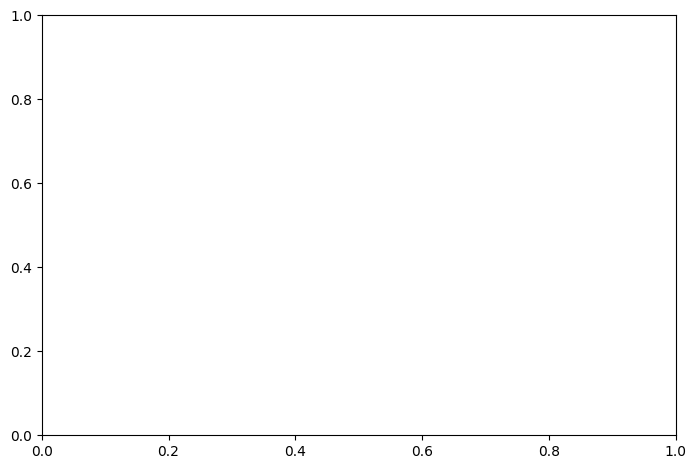

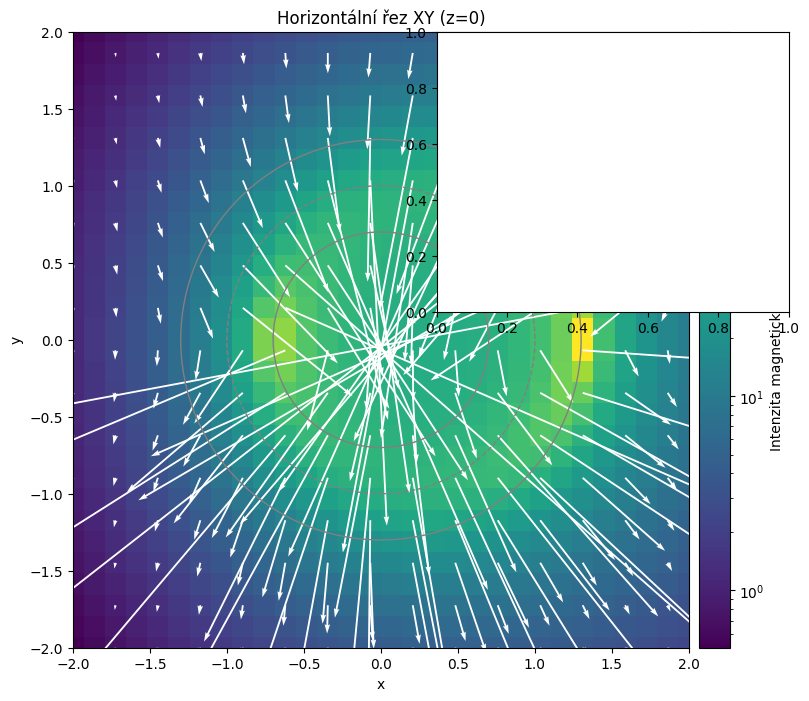

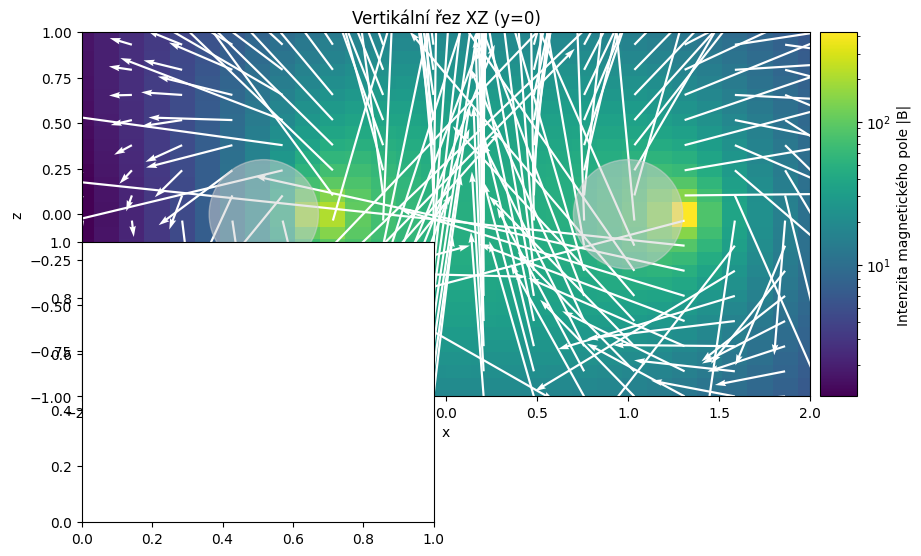

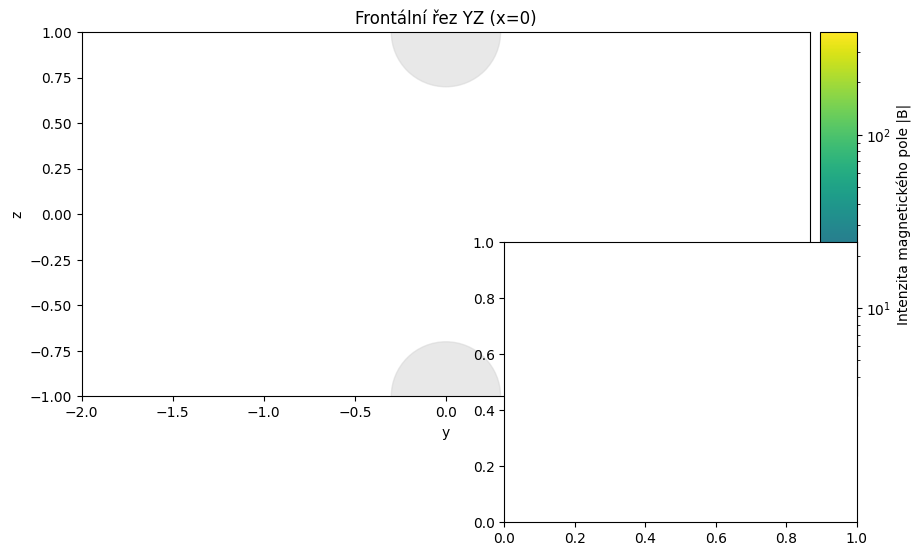

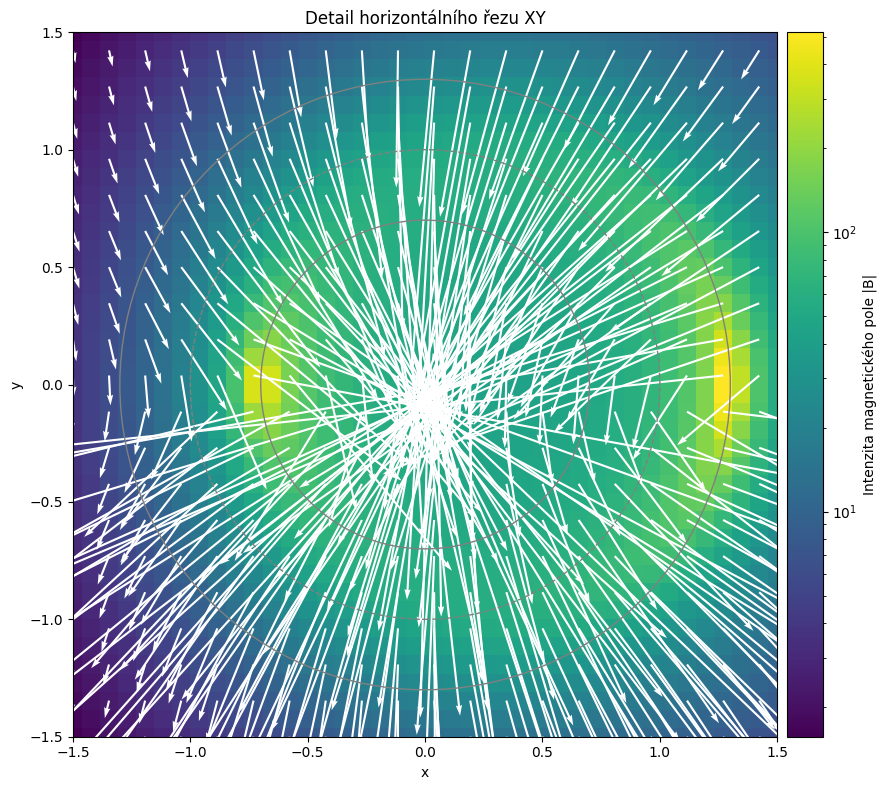

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Parametry toroidu
R = 1.0  # Hlavní poloměr toroidu (střed trubice)
a = 0.3  # Malý poloměr průřezu toroidu
I = 1.0  # Proud v toroidu (relativní jednotky)
N = 100  # Počet závitů
mu_0 = 1.0  # Permeabilita vakua (relativní jednotky)

# Funkce pro výpočet magnetického pole v bodě (x, y, z) od proudové smyčky v toroidu
def B_field_element(x, y, z, phi):
    # Pozice elementu proudu na toroidu
    element_x = (R + a * np.cos(phi)) * np.cos(phi)
    element_y = (R + a * np.cos(phi)) * np.sin(phi)
    element_z = a * np.sin(phi)
    
    # Směr elementu proudu (tečna k smyčce)
    dl_x = -(R + a * np.cos(phi)) * np.sin(phi)
    dl_y = (R + a * np.cos(phi)) * np.cos(phi)
    dl_z = 0
    
    # Vektor od elementu proudu k bodu (x, y, z)
    rx = x - element_x
    ry = y - element_y
    rz = z - element_z
    
    # Vzdálenost
    r = np.sqrt(rx**2 + ry**2 + rz**2)
    
    if r < 1e-10:  # Předejdeme dělení nulou
        return 0, 0, 0
    
    # Křížový součin dl × r
    cross_x = dl_y * rz - dl_z * ry
    cross_y = dl_z * rx - dl_x * rz
    cross_z = dl_x * ry - dl_y * rx
    
    # Biot-Savartův zákon: dB = (mu_0/4pi) * I * (dl × r) / |r|^3
    coef = mu_0 * I / (4 * np.pi * r**3)
    Bx = coef * cross_x
    By = coef * cross_y
    Bz = coef * cross_z
    
    return Bx, By, Bz

# Numerická integrace pro získání celkového pole
def compute_B_field(x, y, z, n_phi=100):
    phi_values = np.linspace(0, 2*np.pi, n_phi)
    dphi = 2*np.pi / n_phi
    
    Bx_total = 0
    By_total = 0
    Bz_total = 0
    
    for phi in phi_values:
        for turn in range(N):  # Pro každý závit
            # Posuneme phi pro různé závity, aby byly rozloženy rovnoměrně
            phi_turn = phi + turn * 2*np.pi/N
            dBx, dBy, dBz = B_field_element(x, y, z, phi_turn)
            Bx_total += dBx * dphi
            By_total += dBy * dphi
            Bz_total += dBz * dphi
    
    return Bx_total, By_total, Bz_total

# Funkce pro vytvoření sítě bodů v rovině
def create_grid(plane, lim=[-2, 2, -2, 2], n=40):
    if plane == 'xy':
        x = np.linspace(lim[0], lim[1], n)
        y = np.linspace(lim[2], lim[3], n)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        return X, Y, Z
    elif plane == 'xz':
        x = np.linspace(lim[0], lim[1], n)
        z = np.linspace(lim[2], lim[3], n)
        X, Z = np.meshgrid(x, z)
        Y = np.zeros_like(X)
        return X, Y, Z
    elif plane == 'yz':
        y = np.linspace(lim[0], lim[1], n)
        z = np.linspace(lim[2], lim[3], n)
        Y, Z = np.meshgrid(y, z)
        X = np.zeros_like(Y)
        return X, Y, Z

# Funkce pro výpočet magnetického pole v celé síti
def compute_field_grid(X, Y, Z):
    Bx = np.zeros_like(X)
    By = np.zeros_like(X)
    Bz = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Bx[i, j], By[i, j], Bz[i, j] = compute_B_field(X[i, j], Y[i, j], Z[i, j])
    
    B_mag = np.sqrt(Bx**2 + By**2 + Bz**2)
    return Bx, By, Bz, B_mag

# Vizualizace magnetického pole v rovině
def plot_field(plane, lim=[-2, 2, -2, 2], n=40, skip=2, title=None, draw_toroid=True):
    # Nastavení mřížky
    if plane == 'xy':
        X, Y, Z = create_grid('xy', lim, n)
        x_label, y_label = 'x', 'y'
    elif plane == 'xz':
        X, Y, Z = create_grid('xz', lim, n)
        x_label, y_label = 'x', 'z'
    elif plane == 'yz':
        X, Y, Z = create_grid('yz', lim, n)
        x_label, y_label = 'y', 'z'
    
    # Výpočet pole
    Bx, By, Bz, B_mag = compute_field_grid(X, Y, Z)
    
    # Připravíme komponenty pro vykreslení
    if plane == 'xy':
        u, v = Bx, By
    elif plane == 'xz':
        u, v = Bx, Bz
    elif plane == 'yz':
        u, v = By, Bz
    
    # Vytvoření grafu
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Vykreslení intenzity pole jako barevné mapy
    im = ax.pcolormesh(X, Y if plane == 'xy' else Z, B_mag, cmap='viridis', 
                      norm=LogNorm(vmin=max(B_mag.min(), 1e-10), vmax=B_mag.max()), 
                      shading='auto')
    
    # Přidání barevné škály
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Intenzita magnetického pole |B|')
    
    # Vykreslení vektorů pole
    ax.quiver(X[::skip, ::skip], (Y if plane == 'xy' else Z)[::skip, ::skip], 
              u[::skip, ::skip], v[::skip, ::skip], 
              angles='xy', scale_units='xy', scale=20, width=0.003, color='white')
    
    # Vykreslení toroidu v řezu
    if draw_toroid:
        if plane == 'xy':
            # Horizontální řez (kruh)
            circle = plt.Circle((0, 0), R, fill=False, color='gray', linestyle='--')
            inner_circle = plt.Circle((0, 0), R-a, fill=False, color='gray')
            outer_circle = plt.Circle((0, 0), R+a, fill=False, color='gray')
            ax.add_patch(circle)
            ax.add_patch(inner_circle)
            ax.add_patch(outer_circle)
        elif plane == 'xz':
            # Vertikální řez (dva kruhy)
            circle1 = plt.Circle((R, 0), a, fill=True, color='lightgray', alpha=0.5)
            circle2 = plt.Circle((-R, 0), a, fill=True, color='lightgray', alpha=0.5)
            ax.add_patch(circle1)
            ax.add_patch(circle2)
        elif plane == 'yz':
            # Frontální řez (dva kruhy)
            circle1 = plt.Circle((0, R), a, fill=True, color='lightgray', alpha=0.5)
            circle2 = plt.Circle((0, -R), a, fill=True, color='lightgray', alpha=0.5)
            ax.add_patch(circle1)
            ax.add_patch(circle2)
    
    # Nastavení grafu
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(lim[0], lim[1])
    ax.set_ylim(lim[2], lim[3])
    ax.set_aspect('equal')
    
    if title:
        ax.set_title(title)
    
    return fig, ax

# Vytvoříme tři řezové vizualizace
# Horizontální řez XY
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plot_field('xy', lim=[-2, 2, -2, 2], n=30, skip=2, title='Horizontální řez XY (z=0)')

plt.subplot(2, 2, 2)
plot_field('xz', lim=[-2, 2, -1, 1], n=30, skip=2, title='Vertikální řez XZ (y=0)')

plt.subplot(2, 2, 3)
plot_field('yz', lim=[-2, 2, -1, 1], n=30, skip=2, title='Frontální řez YZ (x=0)')

# Horizontální řez XY s detailem
plt.subplot(2, 2, 4)
plot_field('xy', lim=[-1.5, 1.5, -1.5, 1.5], n=40, skip=2, title='Detail horizontálního řezu XY')

plt.tight_layout()
plt.savefig('magneticke_pole_toroidu.png', dpi=300, bbox_inches='tight')
plt.show()